<h1>Code for Labelling Fake Reviews</h1>
The following criteria have been applied to identify fake reviews:<br>
1. Reviews with same content but from different reviewers<br>
2. Based on the fake reviews by the above 2 criteria, build a corpus from those fake review contents, apply the LSI model to identify reviews    with high similairty to those fake review contents.<br>
3. A reviewer posted multiple reviews for one specific product<br>
4. Reviews with extreme sentiment score from unpopular products<br>
5. Reviews mentioning competitors brand<br>
6. Reviews with more than 5% typos<br>
7. Time interval analysis<br>

### 1. Reviews with same content but from different reviewers

In [97]:
import pandas as pd
import numpy as np
m = pd.read_csv('Cleaned Moisturizers Reviews.csv')
product_info = pd.read_csv('All Moisturizers Ino.csv')
#del m['Unnamed: 0.1']
del product_info['Unnamed: 0']
m.set_index('Unnamed: 0', inplace = True)

In [98]:
id_category = {product_info['item id'][i]: product_info['category 2'][i] for i in range(len(product_info))}
m['category'] = [id_category.get(m['item_id'][i])  for i in m.index]
m = m[(m['category'].notnull())]
moisturizer = m.loc[m['category'] == 'moisturizer']
night_cream = m.loc[m['category'] == 'night cream']
face_oil = m.loc[m['category'] == 'face oil']
mists_essences = m.loc[m['category'] == 'mists & essences']
decollete_neckcream = m.loc[m['category'] == 'decollete & neck cream']
bb_cc_cream = m.loc[m['category'] == 'bb & cc cream']
m.groupby('category').size()

category
bb & cc cream              24288
decollete & neck cream       865
face oil                   33384
mists & essences           21177
moisturizer               107967
night cream                33020
dtype: int64

In [99]:
fake_by_duplicated_index = m.index[m['review'].duplicated(keep = False)]
len(fake_by_duplicated_index)

5485

In [100]:
m['review'].duplicated

<bound method Series.duplicated of Unnamed: 0
0         I've heard so many great things about this--th...
1         Good? Yes! 170 dollars per ounce good? Not qui...
2         I have rosacea and had been using First Aid se...
3         GOT A FREE SAMPLE SIZE AND UNFORTUNATELY IT'S ...
4         Pricey? You betcha! Worth it? Yup!! My skin ha...
                                ...                        
237294    I bought this because other reviews said it wa...
237295    I really like this product for its SPF propert...
237296    This is great to layer over a tinted cream for...
237297    This product doesn't cover the skin well and d...
237298    I was looking for a silicone free product to r...
Name: review, Length: 220701, dtype: object>

In [101]:
fake_by_duplicated_index

Int64Index([   619,    867,   1067,   1317,   1787,   1814,   2939,   3744,
              3815,   3903,
            ...
            231526, 231544, 231547, 231917, 232004, 233009, 233164, 234137,
            235889, 236667],
           dtype='int64', name='Unnamed: 0', length=5485)

In [102]:
duplicated_contents = set(m['review'][fake_by_duplicated_index])

In [103]:
duplicated_contents

{"Very hydrating. I'm using this as a preventative measure for any fine lines that want to creep up. I am using this as a substitution for my serum, and doing the Kate Somerville Age Delay over as my moisturizer, when I want to do some anti-aging. It's fast absorbing too which is really important. Definitely would recommend.",
 "I'm on my second bottle of this ~ It lasts forever! I use it on my smile lines and forehead creases NOT all over my face so it will really go a long way. My smile lines are no more. My forehead lines are pretty deep so they are still there but if I don't use it they are much worse. I love the texture, it feels like it settles in and stays. Smells great too. Hands down best wrinkle cream I've tried so far.",
 'Leaves your skin nice and fresh! Does what it says it does!',
 'As I’ve gotten older skin care has become more important than beauty products. I’ve been using this moisturizer that I received complimentary from Influenster. I fell in love with this immedia

Word Cloud of duplicated and partially overlapped review contents

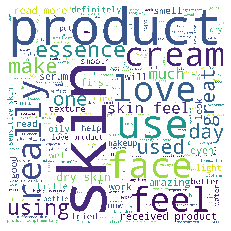

In [104]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
m_stop_words = STOPWORDS.union({'moisturizer'})
#documents = set(m['review'][fake_by_overlapped_index]) + duplicated_contents
documents = str(duplicated_contents)
wordcloud = WordCloud(stopwords=m_stop_words,background_color='white',width=5000,height=5000).generate(documents)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### 2. Use LSI model to identify reviews with high similairty to the above fake review contents

In [105]:
#LSI model setup
from gensim.similarities.docsim import Similarity
from gensim import corpora, models, similarities
texts = [[word for word in document.lower().split()
            if word not in STOPWORDS and word.isalnum()]
            for document in duplicated_contents]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
lsi = models.LsiModel(corpus, id2word=dictionary)
index = similarities.MatrixSimilarity(lsi[corpus]) 


def similarity_score(review):
    vec_bow = dictionary.doc2bow(review.lower().split())   # (id, freq) list of the new document
    vec_lsi = lsi[vec_bow]                                       #input to the index
    sims = index[vec_lsi]
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    return sims[0]   #return the highest similarity score

#function to return review index with similarity score > 0.9
def high_similarity_reviews(df, dup_index):
    fake_index = []
    similar_score = []
    similar_index =[]
    for i in df.index:
        if i not in dup_index:
            if i in [100, 1000, 5000, 10000, 20000, 50000, 60000, 100000, 150000]:
                print(i)
            score = similarity_score(df['review'][i])
            if score[1] >= 0.9:
                fake_index.append(i)
                similar_score.append(score[1])
                similar_index.append(score[0])
    return fake_index, similar_score, similar_index
fake_by_similarity_index, fake_by_similarity_score, fake_by_similarity_other_index = high_similarity_reviews(m, fake_by_duplicated_index)

100
1000
5000
10000
20000
50000
60000
100000
150000


### 3. A reviewer posted multiple reviews for one specific product

In [106]:
def multiple_reviews(row):
    if row['no_of_reviews'] > 1 and row['review_rating'] == 1:
        #print(row['review_rating'])
        return 1
    elif row['no_of_reviews'] > 1 and row['review_rating'] == 5:
        #print(row['review_rating'])
        return 1
    else:
        return 0

In [107]:
m['no_of_reviews']=m.groupby(['user_name','item_id'])['user_name'].transform('count')

In [108]:
m['multiple'] = m.apply(multiple_reviews, axis = 1)

In [109]:
fake_by_multiple_reviews_index = m[m['multiple'] == 1].index

In [110]:
fake_by_multiple_reviews_index

Int64Index([ 12780,  12804,  13260,  13363,  16453,  16454,  16455,  16456,
             16457,  16458,
            ...
            237029, 237034, 237049, 237064, 237098, 237103, 237139, 237164,
            237175, 237232],
           dtype='int64', name='Unnamed: 0', length=8099)

In [111]:
m['review_rating'][fake_by_multiple_reviews_index].describe()

count    8099.000000
mean        4.784665
std         0.902814
min         1.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: review_rating, dtype: float64

### 4. Reviews with extreme sentiment score from unpopular products

In [112]:
product_info.describe()

,item id,loves
count,9.030000e+02,903.000000
mean,1.893205e+06,16346.899225
std,3.566954e+05,28358.665638
min,7.447600e+04,0.000000
25%,1.717638e+06,2047.500000
50%,1.988542e+06,5184.000000
75%,2.167934e+06,16933.500000
max,2.311439e+06,217011.000000


In [113]:
m.groupby('total_reviews').size().describe()

count     364.000000
mean      606.321429
std       712.590918
min        17.000000
25%       165.000000
50%       333.500000
75%       756.250000
max      6081.000000
dtype: float64

We use number of loves indicated on the website and the reviews volume to measure the popularity of a product.<br>
<li>Cutoff for loves: <br>
    We look at the products whose loves are below the 25% percentile. <br>
    The 25% percentile is 2047.5, so we choose 2047 as the cutoff for loves.<br>
<li>Cutoff for review volumns:<br>
    We look at the products whose review volumes are below the 25% percentile.<br>
    The 25% percentile is 165, so we choose 165 as the cutoff for review volumes.<br>
    
Products with loves lower than 2047 or number of reviews lower than 168 are subjects for fake reviews inspection.

In [114]:
#filter products with loves lower than 2047 or number of reviews lower than 165
ids = product_info['item id'][product_info['loves']<=2047]
suspect = m.loc[m['item_id'].isin(list(ids)) | (m['total_reviews'] <= 165)]

After identifying suspect, use VADER to identify extreme reviews

In [115]:
#sentiment score function
def sentiment_score(review):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    from nltk import sent_tokenize,word_tokenize
    analyzer = SentimentIntensityAnalyzer()
    pos=compound=neu=neg=0
    sentences = sent_tokenize(review)
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        pos+=vs['pos']/(len(sentences))
        compound+=vs['compound']/(len(sentences))
        neu+=vs['neu']/(len(sentences))
        neg+=vs['neg']/(len(sentences))
    return compound

In [116]:
suspect['sentiment score'] = [sentiment_score(review_text) for review_text in suspect['review']]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [117]:
suspect['sentiment score'].describe()

count    21696.000000
mean         0.278943
std          0.232795
min         -0.900900
25%          0.134189
50%          0.278064
75%          0.424168
max          0.984300
Name: sentiment score, dtype: float64

Reviews with absolute value of sentiment scores above 0.8 are identified as fake.

In [118]:
fake_by_sentiment_reviews = suspect.loc[abs(suspect['sentiment score']) >= 0.8]
fake_by_sentiment_index = suspect.loc[abs(suspect['sentiment score']) >= 0.8].index
fake_by_sentiment_reviews

,item_id,total_reviews,user_name,skin_type,skin_tone,age_range,review_title,review,review_rating,not_helpful,helpful,free_product,recommend,review_time,category,no_of_reviews,multiple,sentiment score
Unnamed: 0,,,,,,,,,,,,,,,,,,
14510,1785229,122,laurasn,Combination,Medium,35-44,Love!,My husband bought me the entire line of SK-II....,5,8,2,0,0,15 Aug 2016,moisturizer,1.0,0,0.84020
33543,2060960,64,isastern,Oily,Fair,NaN,I love La Mer products,I’m on my 30’s so I think it’s worth investing...,5,0,9,0,1,15 Sep 2018,moisturizer,1.0,0,0.86005
48002,2234110,140,Zanesmom2016,Combination,Tan,NaN,Great stuff!!,I love how this makes my skin feel free super ...,5,0,0,0,1,12-Aug-19,moisturizer,1.0,0,0.94770
48007,2234110,140,mommyoftwins18,Combination,Tan,NaN,Works great,This cream makes my skin feel amazing and I lo...,5,0,0,1,1,12-Aug-19,moisturizer,1.0,0,0.88340
48030,2234110,140,lissa757,Combination,Medium,NaN,NaN,I really love this cream it has spf in it and ...,4,0,0,0,1,10-Aug-19,moisturizer,1.0,0,0.83990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236698,844480,95,taramariev,Dry,NaN,18-24,I'm 21 and I love this,I'm 21 so I don't use this for wrinkles but ju...,5,1,1,0,0,26 Jun 2013,moisturizer,2.0,1,0.91840
236701,844480,95,joal,Combination,Medium,over 54,Dont wait.,"Great Product, A little pricey for me being on...",4,0,1,0,0,5 Jan 2009,moisturizer,1.0,0,0.88900
236728,844480,95,Chess123,NaN,NaN,NaN,Love it,"Great product, makes my skin feel amazing and ...",5,2,0,0,0,18 Dec 2013,moisturizer,1.0,0,0.89100


### 5. Reviews mentioning competitors brand

In [119]:
#!pip install plotly
#!pip install pyspellchecker

In [120]:
# convert all text to lowercase and create a new column combining review_title and review
m['review_title'] = m['review_title'].fillna(' ')
m['review_title'] = m['review_title'].apply(lambda x: x.lower())
m['review'] = m['review'].apply(lambda x: (' '+x).lower())
m['title_and_review'] = m['review_title']+m['review']

In [121]:
product_info

,brand name,category 1,category 2,item id,loves,price,product name,rating
0,la mer,moisturizer,moisturizer,1932201,70767.0,180.0,crème de la mer,4
1,kiehl's since 1851,moisturizer,moisturizer,2172526,77375.0,30.0,ultra facial cream,4
2,drunk elephant,moisturizer,moisturizer,2025633,192716.0,68.0,protini™ polypeptide moisturizer,4
3,la mer,moisturizer,moisturizer,1932235,25835.0,180.0,the moisturizing soft cream,4
4,tatcha,moisturizer,moisturizer,2181006,68333.0,68.0,the dewy skin cream,4
...,...,...,...,...,...,...,...,...
898,clinique,moisturizer,decollete & neck cream,2240315,125.0,69.0,clinique smart clinical™ md multi-dimensional ...,3
899,eve lom,moisturizer,decollete & neck cream,2286896,170.0,60.0,time retreat face & neck sheet mask,N
900,maelys cosmetics,moisturizer,decollete & neck cream,2267342,665.0,39.0,b-perky lift & firm breast mask,4
901,nurse jamie,moisturizer,decollete & neck cream,2112068,1638.0,28.0,neck & décolléte wrap skin perfecting silicone...,2


In [122]:
# Brand Mentioning
def reviews_mentioning_brands(df, product_info):
    reviewsdf = df
    productsdf = product_info

    import plotly.graph_objects as go
    
    #change reviews to lower case, use .loc to aviod chain index
    reviewsdf.loc[:,'title_and_review'] = reviewsdf.loc[:,'title_and_review'].str.lower()
    
    #get all brands of this category, and a dictionary of product item id and brand name 
    #add spaces before and after brand name to reduce errors of searching brands in reviews
    #e.g. if not doing so, the brand tarte appears in word "started", and would be regarded as a count 
    match = productsdf.set_index('item id')['brand name'].to_dict()
    for i in match: 
        match[i] = ' {0} '.format(match[i])
    brands_names = productsdf['brand name'].unique()
    brands = [' {0} '.format(brand) for brand in brands_names]

    #find mentioned brands and count in every review 
    review_dict = reviewsdf['title_and_review'].to_dict()
    mentions = {}
    counts = {}
    for brand in brands:
        for review_index in review_dict:
            if brand in review_dict[review_index]:
                mentions[review_index] = brand
                counts[review_index] = review_dict[review_index].count(brand)
    
    #add mentioned brand, count, corresponing brand for every review
    reviewsdf['brand'] = reviewsdf['item_id'].map(match)
    reviewsdf['mentions'] = pd.Series(mentions)
    reviewsdf['counts'] = pd.Series(counts)
    reviewsdf['counts'] = reviewsdf['counts'].fillna(0)
    
    #make a pie plot to show the results
    brands_mention = reviewsdf.groupby(['counts']).count()['total_reviews'].to_dict()
    mentions_pie = go.Figure(data=[go.Pie(labels= [i for i in brands_mention], 
                                    values=[brands_mention[i] for i in brands_mention],
                                    hole=.3, title_text = 'Mentions')])
    mentions_pie.update_layout(height=600, width=600)
    mentions_pie.show()
    
    #if a review mentions any brand more than or equal to three times, it is labled as fake 
    fake = []
    for i in reviewsdf[reviewsdf['counts'] >= 2].index:
        fake.append(i)
        
    return (reviewsdf,fake)

    

In [141]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [123]:
sample_df, fake_by_competitors_index = reviews_mentioning_brands(m, product_info)

In [124]:
sample_df.head()

,item_id,total_reviews,user_name,skin_type,skin_tone,age_range,review_title,review,review_rating,not_helpful,...,free_product,recommend,review_time,category,no_of_reviews,multiple,title_and_review,brand,mentions,counts
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,1932201,580,zombified,Combination,Tan,NaN,you'll get hooked!,i've heard so many great things about this--t...,5,220,...,0,1,7 Sep 2017,moisturizer,1.0,0,you'll get hooked! i've heard so many great th...,la mer,la mer,3.0
1,1932201,580,Stripper,Dry,Medium,NaN,good but not 170 dollars per ounce good,good? yes! 170 dollars per ounce good? not qu...,4,70,...,0,1,30 Apr 2018,moisturizer,1.0,0,good but not 170 dollars per ounce good good? ...,la mer,la mer,1.0
2,1932201,580,alephbet,Oily,Medium,35-44,unbelievable!,i have rosacea and had been using first aid s...,5,60,...,0,0,22 Mar 2017,moisturizer,1.0,0,unbelievable! i have rosacea and had been usin...,la mer,la mer,1.0
3,1932201,580,ShelbyWW,Combination,Medium,NaN,,got a free sample size and unfortunately it's...,5,38,...,0,1,12 Sep 2018,moisturizer,1.0,0,got a free sample size and unfortunately it'...,la mer,NaN,0.0
4,1932201,580,meshybelle,Combination,Medium,45-54,worth it.,pricey? you betcha! worth it? yup!! my skin h...,5,52,...,0,0,23 May 2017,moisturizer,1.0,0,worth it. pricey? you betcha! worth it? yup!! ...,la mer,NaN,0.0


In [125]:
len(fake_by_competitors_index)

2537

### 6. Reviews with more typos above 95 percentile

In [126]:
def reviews_typo(reviewsdataframe):

    import re
    from spellchecker import SpellChecker
    spell = SpellChecker()
    
    # analyze typo for reviews with extreme ratings 
    reviews_extremeratings = reviewsdataframe[(reviewsdataframe['review_rating'] == 1) | (reviewsdataframe['review_rating'] == 5)]
    extreme_reviews = reviews_extremeratings['title_and_review']
    
    # use regex to findall words and abbrevations in the review
    pattern = r'[a-zA-Z]+[\’]*[\']*[a-zA-Z]+'
    allwords = {}
    mis = {}
    for i in extreme_reviews.index:
        match = re.findall(pattern,extreme_reviews[i])
        allwords[i] = match
        misspelled = spell.unknown(match)
        mis[i] = misspelled

    # since SpellChecker would identify couldn't as correct, but i've as typo, we filter abbreviations from last step
    filtered_mis = {}
    pattern2 = r'^[a-zA-Z]+$'
    for i in mis:
        matches = []
        for words in mis[i]:
            match = re.search(pattern2,words)
            if match:
                matches.append(match.string)
        filtered_mis[i] = matches

    # analyze what percentage of a review is typo, choose 95 percentile  as the cutoff to label typo
    # limitaion: SpellChecker only works for English, reviews in other languages will be identified as typo though they may actually not 
    ratio = {}
    for i in allwords:
        ratio[i] = len(filtered_mis[i])/len(allwords[i])
    cutoff = float(pd.Series(ratio).quantile([0.95]))
    fake = {}
    print(ratio)
    for i in ratio:
        if ratio[i] >= cutoff:
            fake[i] = 1         
    return fake

In [127]:
fake_by_typos_index = reviews_typo(m)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [128]:
len(fake_by_typos_index)

7682

### 7. Time interval analysis: 
Do weekly analysis of the volume of reviews for each product.<br>
Define a threshold (1.96σ above average) for rapid growth and extract reviews in such weeks, then apply the following two criteria:<br>
<li>Reviews mentioning competitor brands → fake
<li>Look at the ‘not helpful’ versus ‘helpful’ in each review, if unhelpfulness exceeds 70% → fake


In [129]:
# Times interval analysis
import csv
import matplotlib.pyplot as plt
import datetime
import statistics

brand_dict = {}
brands = set()
#portion_rate = 0.0

def loadData(file_name):
    data = {}
    file = open(file_name)
    csv_file = csv.reader(file)
    #print(csv_file)

    #header = next(csv_file)
    #index = 0

    for line in csv_file:
        #print(line)
        try:
# =============================================================================
#             index += 1
#             if index >= 580:
#                 break
# =============================================================================

            index = line[0]
            item_id = line[1]
            review = line[8]
            not_helpful = line[10]
            helpful = line[11]
            review_time = line[14]
            (year, week, weekday) = datetime.datetime.strptime(review_time, "%d %b %Y").isocalendar()
            if item_id not in data:
                data[item_id] = {}

            if (year, week) not in data[item_id]:
                data[item_id][(year, week)] = []

            data[item_id][(year, week)].append([index, review, not_helpful, helpful])
            
            # dict of dict; item_id as the key, with a dict as value, in which (year, week) as the key and reviews
            # and helpfulness as the value of the inner dict
        except:
            try:
                (year, week, weekday) = datetime.datetime.strptime(review_time, "%d-%b-%Y").isocalendar()   #there are two types of datetime in our data
            except:
                pass
    return data
        
file_name = "Cleaned Moisturizers Reviews.csv"
data = loadData(file_name)

In [130]:
def threshold(item_id):
    counts = []
    for (key, value) in data[item_id].items():
        counts.append(len(value))
    
    avg = sum(counts) / len(counts)
    sd = statistics.pstdev(counts)
    threshold = avg + 1.96 * sd
    return threshold


data_new = {}
def weeks():
    for (item, values) in data.items():

        limit = threshold(item)
        #print(limit)
        for (week, reviews) in values.items():
            if len(reviews) >= limit and len(reviews) > 30:
                if item not in data_new:
                    data_new[item] = {}
                data_new[item][week] = reviews      
weeks()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



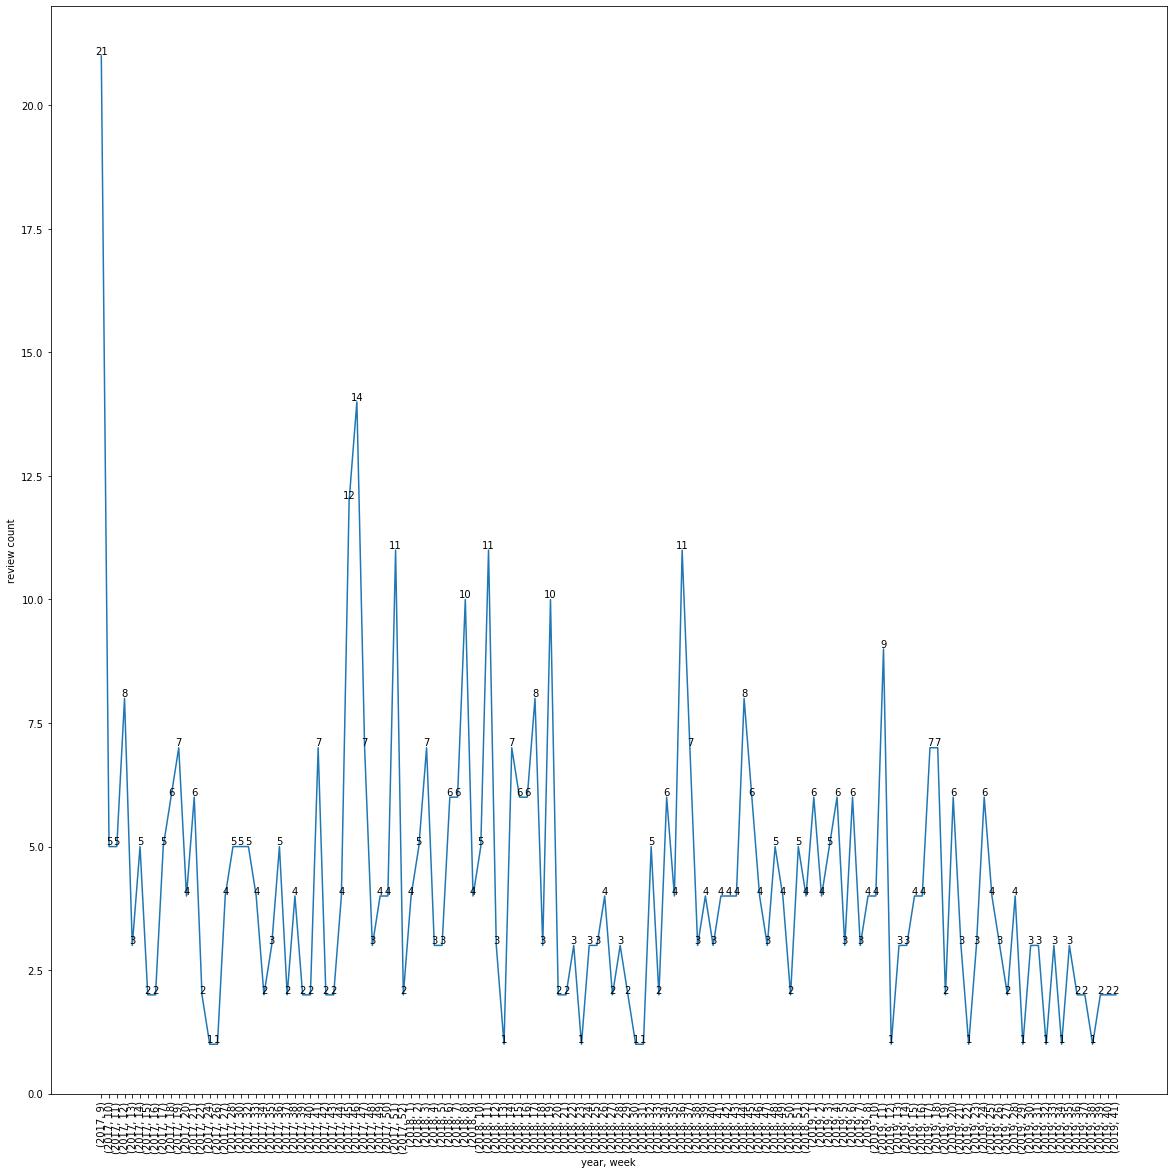

In [131]:
def load_brand_dict(brand_data_file):
    file = open(brand_data_file)
    csv_reader = csv.reader(file)
    header = next(csv_reader)
    for line in csv_reader:
        brand = line[1]
        item_id = line[4]
        brand_dict[item_id] = brand
        brands.add(brand)

brand_data_file = 'All Moisturizers Ino.csv'
load_brand_dict(brand_data_file)
#brands
#brand_dict


def draw(item_id):
    print(data)
    item_reviews_dict = data[item_id]
    # print(item_reviews_dict)

    item_reviews_count_dict = {}
    for week, reviews in item_reviews_dict.items():
        item_reviews_count_dict[week] = len(reviews)
    # print(item_reviews_count_dict)
    # sort by year and week
    sort = sorted(item_reviews_count_dict.items(), key=lambda x: x[0], reverse=False)

    x = []
    y = []
    
    for (week_key, count) in sort:
        x.append(str(week_key))
        y.append(count)

    plt.figure(figsize=(20, 20))
    plt.plot(x, y)
    plt.xticks(rotation=90)

    plt.xlabel('year, week')

    plt.ylabel('review count')

    for a, b in zip(x, y):
        if b == 21:
            plt.text(a, b, b, ha='center', va='bottom')
        else:
            plt.text(a, b, b, ha='center', va='bottom')

    plt.show()
    
draw('1932201')

In [132]:
def draw_key_point(item_id, key_points):
    # select certain time intervals and see the change in review numbers
    key_points = [str(i) for i in key_points]
    item_reviews_dict = data[item_id]
    # print(item_reviews_dict)

    item_reviews_count_dict = {}
    for week, reviews in item_reviews_dict.items():
        item_reviews_count_dict[week] = len(reviews)
    # print(item_reviews_count_dict)
    # sort by year and week
    sort = sorted(item_reviews_count_dict.items(), key=lambda x: x[0], reverse=False)

    x = []
    y = []
    for (week_key, count) in sort:
        x.append(str(week_key))
        y.append(count)

    plt.figure(figsize=(20, 20))
    plt.plot(x, y)

    # for index in range(len(x)):
    #     if x[index] in key_points:
    #         plt.plot([x[index]], [y[index]], '-o', color="red")
    #     else:
    #         plt.plot([x[index]], [y[index]], '-o', color="blue")
    # plt.plot(x, y)
    plt.xticks(rotation=90)

    plt.xlabel('year, week')

    plt.ylabel('review count')

    for a, b in zip(x, y):
        if b == 21:
            plt.text(a, b, b, ha='center', va='bottom', )
        else:
            plt.text(a, b, b, ha='center', va='bottom')

    for key_point in key_points:
        print(key_point)
        plt.plot([key_point], [y[x.index(key_point)]], '-o', color="red")
    plt.show()



indexes = []
def select(item_id):
    #item_id = str(item_id)
    
    reviews = data_new[item_id]
    #reviews_count = len(reviews)
    #print(f'item_id: {item_id}, year: {year}, week: {week}, reviews count: {reviews_count}')

    portion_reviews = []
    competitive_brand_reviews = []
    
    for (week, info) in reviews.items():
        
        for review in info:
            index = review[0]
            review_text = review[1].lower()
            not_helpful = int(review[2])
            helpful = int(review[3])

            try:
                portion = not_helpful / (helpful + not_helpful)
            except:
                portion = 0

            # analyze not_helpful helpful rate
            portion_rate = 0.7
            if portion > portion_rate:
                portion_reviews.append((review_text))
                indexes.append(index)

            # analyze competitive brand
            review_word_list = review_text.split(' ')
            competitive_brands = set()
            for review_word in review_word_list:
                if review_word in brands and review_word not in brand_dict[item_id]:
                    competitive_brands.add(review_word)

            if len(list(competitive_brands)):
                competitive_brand_reviews.append((review_text, list(competitive_brands)))
                if index not in indexes:
                    indexes.append(index)
                
    return portion_reviews, competitive_brand_reviews, indexes
    
for (item_id, values) in data_new.items():
    select(item_id)

fake_by_analysis_index = [int(i) for i in indexes] 
fake_by_analysis_index.sort()

In [133]:
len(fake_by_analysis_index)

2050

# Combine all the indices and label fake reviews

In [134]:
fake_index_set = set(list(fake_by_duplicated_index) + list(fake_by_sentiment_index) + list(fake_by_multiple_reviews_index )  + list(fake_by_similarity_index) + list(fake_by_competitors_index) + list(fake_by_typos_index) + list(fake_by_analysis_index))
len(fake_index_set)

22682

In [135]:
index_dict = {i: 1 if i in fake_index_set else 0 for i in m.index}
m['fake'] =pd.Series(index_dict)

In [136]:
#m.to_csv('All Moisturizers Labelled.csv')

In [137]:
id_category = {product_info['item id'][i]: product_info['category 2'][i] for i in range(len(product_info))}

In [138]:
m['category'] = [id_category.get(m['item_id'][i])  for i in m.index]
m = m[(m['category'].notnull())]
moisturizer = m.loc[m['category'] == 'moisturizer']
night_cream = m.loc[m['category'] == 'night cream']
face_oil = m.loc[m['category'] == 'face oil']
mists_essences = m.loc[m['category'] == 'mists & essences']
decollete_neckcream = m.loc[m['category'] == 'decollete & neck cream']
bb_cc_cream = m.loc[m['category'] == 'bb & cc cream']
m.groupby('category').size()

category
bb & cc cream              24288
decollete & neck cream       865
face oil                   33384
mists & essences           21177
moisturizer               107967
night cream                33020
dtype: int64

In [139]:
# moisturizer.to_csv('Labelled_mositurizer.csv')
# night_cream.to_csv('Labelled_night_cream.csv')
# face_oil.to_csv('Labelled_face_oil.csv')
# mists_essences.to_csv('Labelled_mists_essences.csv')
# decollete_neckcream.to_csv('Labelled_decollete_neckcream.csv')
# bb_cc_cream.to_csv('Labelled_bb_cc_cream.csv')

In [147]:
m.groupby('item_id').describe()

total_reviews                                                 \
                count   mean  std    min    25%    50%    75%    max   
item_id                                                                
74476           258.0  258.0  0.0  258.0  258.0  258.0  258.0  258.0   
112680          310.0  343.0  0.0  343.0  343.0  343.0  343.0  343.0   
112706           79.0   79.0  0.0   79.0   79.0   79.0   79.0   79.0   
153726          267.0  272.0  0.0  272.0  272.0  272.0  272.0  272.0   
241539          229.0  229.0  0.0  229.0  229.0  229.0  229.0  229.0   
...               ...    ...  ...    ...    ...    ...    ...    ...   
2288942          99.0  102.0  0.0  102.0  102.0  102.0  102.0  102.0   
2294635           2.0    2.0  0.0    2.0    2.0    2.0    2.0    2.0   
2297257           4.0    1.0  0.0    1.0    1.0    1.0    1.0    1.0   
2297372           4.0    4.0  0.0    4.0    4.0    4.0    4.0    4.0   
2301943           2.0    2.0  0.0    2.0    2.0    2.0    2.0    2.0   

        review_rating            ... counts        fake                      \
                count      mean  ...    75%  max  count      mean       std   
item_id                          ...                                          
74476           258.0  4.329457  ...   0.00  8.0  258.0  0.069767  0.255250   
112680          310.0  4.319355  ...   0.00  2.0  310.0  0.106452  0.308913   
112706           79.0  4.708861  ...   0.00  1.0   79.0  0.151899  0.361216   
153726          267.0  4.486891  ...   0.00  2.0  267.0  0.089888  0.286558   
241539          229.0  4.471616  ...   0.00  3.0  229.0  0.179039  0.384225   
...               ...       ...  ...    ...  ...    ...       ...       ...   
2288942          99.0  4.666667  ...   0.00  2.0   99.0  0.060606  0.239821   
2294635           2.0  3.000000  ...   0.75  1.0    2.0  0.000000  0.000000   
2297257           4.0  3.000000  ...   0.00  0.0    4.0  1.000000  0.000000   
2297372           4.0  3.250000  ...   0.00  0.0    4.0  0.000000  0.000000   
2301943           2.0  4.000000  ...   0.00  0.0    2.0  0.000000  0.000000   

                                  
         min  25%  50%  75%  max  
item_id                           
74476    0.0  0.0  0.0  0.0  1.0  
112680   0.0  0.0  0.0  0.0  1.0  
112706   0.0  0.0  0.0  0.0  1.0  
153726   0.0  0.0  0.0  0.0  1.0  
241539   0.0  0.0  0.0  0.0  1.0  
...      ...  ...  ...  ...  ...  
2288942  0.0  0.0  0.0  0.0  1.0  
2294635  0.0  0.0  0.0  0.0  0.0  
2297257  1.0  1.0  1.0  1.0  1.0  
2297372  0.0  0.0  0.0  0.0  0.0  
2301943  0.0  0.0  0.0  0.0  0.0  

[721 rows x 80 columns]